In [ ]:
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt

from jaxlayerlumos import stackrt
from jaxlayerlumos.utils_materials import get_n_k_surrounded_by_air
from jaxlayerlumos.utils_spectra import get_frequencies_visible_light, convert_frequencies_to_wavelengths
from jaxlayerlumos.utils_layers import get_thicknesses_surrounded_by_air
from jaxlayerlumos.utils_units import convert_nm_to_m

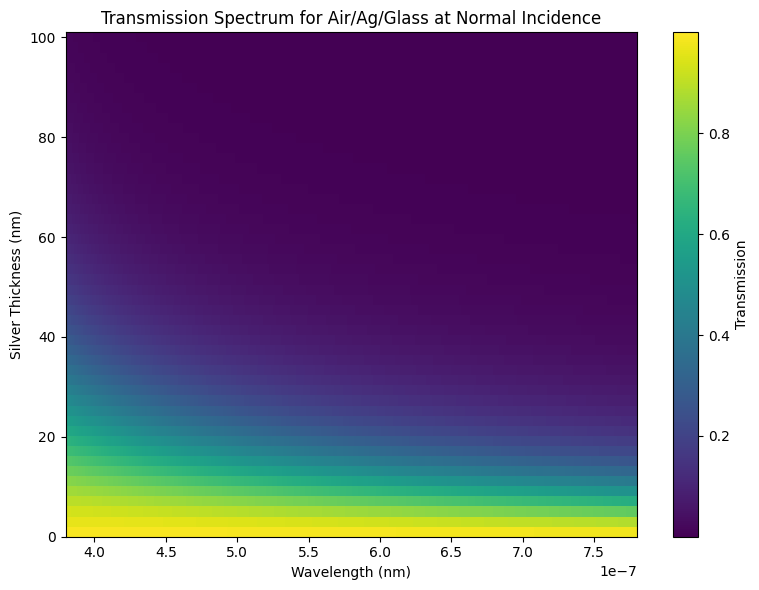

In [3]:
# Get visible light frequencies and corresponding wavelengths (in nm)
frequencies = get_frequencies_visible_light()            # shape: (num_freq,)
wavelengths = convert_frequencies_to_wavelengths(frequencies)  # wavelengths in nm

# Define a range for the silver thickness (in nm)
silver_thicknesses = jnp.linspace(1.0, 100.0, 50)  # 50 points from 1 nm to 100 nm

# Pre-calculate the substrate optical constants for "Glass"
# Note: get_n_k_surrounded_by_air(["Glass"], frequencies) returns [air, Glass, air];
# we take the middle element to represent glass.
n_k_glass_full = get_n_k_surrounded_by_air(["FusedSilica"], frequencies)  # shape: (3, num_freq)
glass_n_k = n_k_glass_full[1, :]  # glass optical constants over visible

# Prepare an array to hold the computed transmission spectra.
# Each spectrum is computed at normal incidence.
transmission_spectra = []

# Define the incidence angle (0° for normal incidence)
angle = jnp.array([0.0])

# Loop over silver thickness values
for t_ag in silver_thicknesses:
    # For the silver layer, the helper function expects an array (with units in nm)
    # It will pad the stack with air at both boundaries.
    thicknesses = get_thicknesses_surrounded_by_air(jnp.array([t_ag]))
    # Convert the thickness array from nm to m
    layers = convert_nm_to_m(thicknesses)  # resulting array has three entries: [air, Ag, air]

    # Get the refractive indices for an "Ag" layer surrounded by air
    # This returns an array with shape (3, num_freq): [air, Ag, air]
    n_k_stack = get_n_k_surrounded_by_air(["Ag"], frequencies)

    # Replace the default air substrate with glass.
    # Since n_k_stack is a JAX array (and immutable), we use the .at[] setter.
    n_k_stack = n_k_stack.at[2].set(glass_n_k)

    # Compute the reflection and transmission coefficients using the transfer-matrix method.
    R_TE, T_TE, R_TM, T_TM = stackrt(n_k_stack, layers, frequencies, angle)

    # Remove the angle dimension (squeezing the first axis) and average the two polarizations.
    T_TE_spec = jnp.squeeze(T_TE, axis=0)
    T_TM_spec = jnp.squeeze(T_TM, axis=0)
    T_avg = (T_TE_spec + T_TM_spec) / 2.0

    # Store the transmission spectrum (convert to a NumPy array for plotting)
    transmission_spectra.append(np.array(T_avg))

# Convert list into a 2D NumPy array:
#   shape: (num_thicknesses, num_wavelengths)
transmission_spectra = np.array(transmission_spectra)

# Create a color map plot showing transmission vs. wavelength (x-axis) and silver thickness (y-axis)
plt.figure(figsize=(8, 6))
# Create a meshgrid for plotting
X, Y = np.meshgrid(wavelengths, np.array(silver_thicknesses))
cmap_plot = plt.pcolormesh(X, Y, transmission_spectra, shading='auto', cmap='viridis')
plt.colorbar(cmap_plot, label="Transmission")
plt.xlabel("Wavelength (nm)")
plt.ylabel("Silver Thickness (nm)")
plt.title("Transmission Spectrum for Air/Ag/Glass at Normal Incidence")
plt.tight_layout()
plt.show()